## УСЛОВИЕ:
Скачиваем и работаем с данными train.csv.

Необходимо произвести предобработку данных, обучить модели на алгоритмах, рассмотренных в уроках, оценить модели с помощью рассмотренных метрик и объяснить выбор определенной метрики.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

Загрузим датасет

In [3]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Подсчитаем процент пропущенных данных в каждом признаке

In [5]:
missing = df.isna().mean() * 100
missing = missing[missing > 0].sort_values(ascending=False)
missing

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

Удалим признаки с большой долей пропусков

In [6]:
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [7]:
df.shape

(1460, 76)

Удалим строки с оставшимися пропусками

In [8]:
df.dropna(axis=0, inplace=True)

In [9]:
df.shape

(1094, 76)

Сформируем списко признаков  имеющих числовой тип

In [10]:
numerical_features = [x for x in df.columns if df.dtypes[x] != 'object']
numerical_features.remove('Id')
# numerical_features

Сформируем список признаков, имеющих тип 'object'

In [11]:
categorical_features = [x for x in df.columns if df.dtypes[x] == 'object']

In [ ]:
Заменим значения признаков с типом 'object' на числовые

In [12]:
for feature in categorical_features:
    df[feature] = df[feature].astype('category')
    df[feature] = df[feature].cat.codes

Посмотрим на статистику нашего целевого признака 'SalePrice'

In [154]:
df.SalePrice.describe()

count      1094.000000
mean     187033.263254
std       83165.332151
min       35311.000000
25%      132500.000000
50%      165750.000000
75%      221000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Медианная цена равна 165750, а 75% записей имеют цену не превышающую 221000

<AxesSubplot: ylabel='Frequency'>

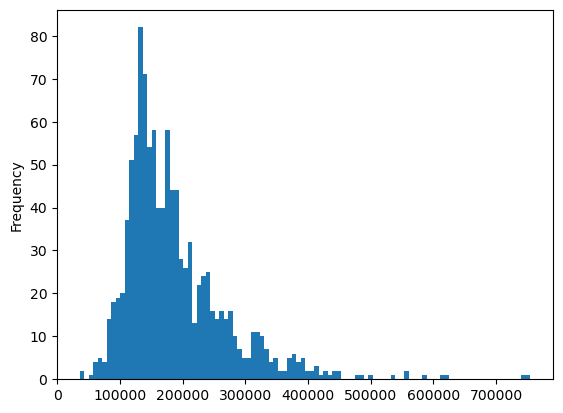

In [13]:
df.SalePrice.plot(kind='hist', bins=100)

<AxesSubplot: ylabel='SalePrice'>

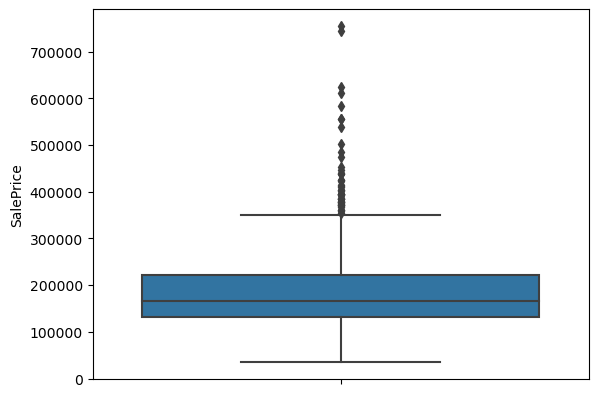

In [16]:
sns.boxplot(data = df, y='SalePrice')

Расчитаем границы 'усов' нашего boxplot

In [26]:
q1, q3 = np.quantile(df.SalePrice, (0.25, 0.75))
q1 - (q3 - q1) * 1.5, q3 + (q3 - q1) * 1.5

(-250.0, 353750.0)

Посмотрим, как много записей выходят за границы усов

In [31]:
df[df.SalePrice > 353750].shape[0]

50

Отбросим записи, которые имеют значения SalePrice, выходящие за границы усов. Сформируем набор признаков, по которому будем строить модель

In [35]:
df_train = df[df.SalePrice <= 353750]
X = np.array(df_train.drop(['Id', 'SalePrice'], axis=1))
X.shape

(1044, 74)

Сформируем набор значенией целевого признака

In [36]:
y = np.array(df_train['SalePrice'])
y.shape

(1044,)

Разобьем наши наборы на тренировоные и тестовые

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Нормализуем X_train и X_test

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Построение моделей

**LinearRegression**

In [65]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# print(f'MSE: {mean_squared_error(y_test, y_pred)}')
# print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2_train: {r2_score(y_train, model.predict(X_train))}')
print(f'R2_test: {r2_score(y_test, y_pred)}')

MAPE: 0.11949474908718016
R2_train: 0.8489393509908894
R2_test: 0.8183733518288423


In [66]:
model = Lasso(alpha=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# print(f'MSE: {mean_squared_error(y_test, y_pred)}')
# print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2_train: {r2_score(y_train, model.predict(X_train))}')
print(f'R2_test: {r2_score(y_test, y_pred)}')

MAPE: 0.11493050674610485
R2_train: 0.8384759407464949
R2_test: 0.8294066285114117


In [67]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# print(f'MSE: {mean_squared_error(y_test, y_pred)}')
# print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2_train: {r2_score(y_train, model.predict(X_train))}')
print(f'R2_test: {r2_score(y_test, y_pred)}')

MAPE: 0.11934847985592603
R2_train: 0.8489393070813176
R2_test: 0.8185979534649755


In [72]:
model = ElasticNet()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# print(f'MSE: {mean_squared_error(y_test, y_pred)}')
# print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2_train: {r2_score(y_train, model.predict(X_train))}')
print(f'R2_test: {r2_score(y_test, y_pred)}')

MAPE: 0.11525158376085454
R2_train: 0.8312196318266925
R2_test: 0.820993924855629


In [71]:
model = HuberRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# print(f'MSE: {mean_squared_error(y_test, y_pred)}')
# print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2_train: {r2_score(y_train, model.predict(X_train))}')
print(f'R2_test: {r2_score(y_test, y_pred)}')

MAPE: 0.09825881777859569
R2_train: 0.7655519937368475
R2_test: 0.8823570342819347
